<a href="https://colab.research.google.com/github/MaxVortman/gpu_hometask/blob/master/Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Интегрирование. Методы прямоугольников, трапеций, Симпсона. Реализовать вычисление по количеству разбиений отрезка (n) и по достигаемой точности (eps) по методу Рунге.

## Численное интегрирование

$\int_a^b f(x) dx \qquad f(x) \in [a,b]$

$\int_a^b f(x) dx = \sum_{k=1}^n A_k f(x_k)$ -- квадратурная формула $x_k \in [a,b]$

$A_k = \int_a^b l_k dx \qquad l_k$ -- коэффициент Лагранжа

$A_k = \int_a^b \frac {w(x)}{(x-x_k)w'(x_k)} dx$

$w(x) = \prod_{k=1}^n (x-x_k)$

$d$ -- целое натуральное, называется алгебраической степенью точности, если квадратурная формула точна для всех полиномов степени не выше $d$ и не точна для полиномов степени $d + 1$

### Квадратурные формулы прямоугольников.

#### Левых:

$\int_a^b f(x) dx = (b-a)f(a) \qquad d = 0$

#### Правых:

$\int_a^b f(x) dx = (b-a)f(b) \qquad d = 0$

#### Серединных:

$\int_a^b f(x) dx = (b-a)f(\frac{a+b}{2}) \qquad d = 1$

### Составная квадратурная формула.

$h = \frac {b-a}{N}, \, x_k= a+ k h, \, f_k=f(x_k), \, k = 0, \dots , N$

$\int_a^b f(x) dx = h \cdot \sum_{k=1}^{N} f(\delta + (k-1)h)$

$\delta = a $ -- левых прям.

$\delta = a+\frac{h}{2} $ -- средних.

$\delta = a + h $ -- правых прям.

### Квадратурная формула трапеций.

#### простая

$\int_a^b f(x) dx = \frac {b-a}{2} (f(a) + f(b)) \qquad d = 1$

#### составная

$\int_a^b f(x) dx = \frac {b-a}{2N} (f_0 + 2 (f_1 + \dots + f_{N-1}) + f_N)$

### Квадратурная формула Симпсона

#### простая

$\int_a^b f(x) dx = \frac {b-a}{6} (f(a) + 4f(\frac{a+b}{2}) + f(b)) \qquad d = 3 $

#### составная

$h=\frac{b-a}{2N} \qquad [x_{k-1}, x_{k+1}] \, k = 0, \dots , N$

$\int_a^b f(x) dx = \frac {b-a}{6N} (f_0 + 4(f_1 + f_3 + \cdots + f_{2N-1}) + 2(f_2 + f_4 + \cdots + f_{2N-2}) + f_{2N})$

### Оценка погрешности

$\exists f^{(d+1)}\in C[a,b]$

$| R_N (f) | = C(b-a)(\frac{b-a}{N})^{d+1} M_{d+1}$

$M_{d+1} = \max_{\xi \in [a,b]}|f^{d+1}(\xi)|$

$C = 1/2$ -- для левых и правых

$C = 1/24$ -- для средних

$C = 1/12$ -- для трапеций

$C = 1/2880$ -- для Симпсона


In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 3.4MB/s 
     |████████████████████████████████| 61kB 19.7MB/s 
     |████████████████████████████████| 460kB 45.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/de/c2/d5/351a6b47b20d417e82a669cf53f8cb4d7b55a57f73cbd05184
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Stored in directory: /root/.cache/pip/wheels/b3/7b/ae/5addd138cd8175503b9782737bada30d0c88310d08c106f9bf
Successfully built pycuda pytools mako


In [0]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time
import matplotlib.pyplot as plt
import math

In [0]:
def rectangles_GPU(a, b, N, delta):
  h = np.float32((b - a) /  (N - 1))
  delta = np.float32(delta)
  a = np.empty(N + 1)
  a = a.astype(np.float32)
  a_gpu = cuda.mem_alloc(a.nbytes)
  cuda.memcpy_htod(a_gpu, a)
  
  mod = SourceModule("""
    __device__ float f(float x)
    {
      return tanh(x);
    }

    __global__ void rectangles(float *a, float h, float delta, int count)
    {
      int k = threadIdx.x;
      for(int i = 0; i < count; ++i)
        a[k + i * 1024] = f(delta + (k + i * 1024) * h);
    }
    """)
  func = mod.get_function("rectangles")
  count = N // 1024
  count = np.int32(count if count != 0 else 1)
  func(a_gpu, h, delta, count, block=(1024 if N > 1024 else N,1,1))
  a_res = np.empty_like(a)
  cuda.memcpy_dtoh(a_res, a_gpu)
  return h * sum(a_res)

In [0]:

def rectangles_GPU_left(a, b, N):
  return rectangles_GPU(a, b, N, a)

def rectangles_GPU_midle(a, b, N):
  return rectangles_GPU(a, b, N, a + (b - a) / (2 * N))

def rectangles_GPU_right(a, b, N):
  return rectangles_GPU(a, b, N, a + (b - a) / N)

In [0]:
def rectangles(f, a, b, N, delta):
  h = (b - a) / (N - 1)
  return h * sum(list(map(lambda k: f(delta + k * h), range(N))))

In [0]:
def rectangles_left(f, a, b, N):
  return rectangles(f, a, b, N, a)

def rectangles_midle(f, a, b, N):
  return rectangles(f, a, b, N, a + (b - a) / (2 * N))

def rectangles_right(f, a, b, N):
  return rectangles(f, a, b, N, a + (b - a) / N)

In [0]:
f = lambda x: math.tanh(x)

In [0]:
def measure_time(func):
  t0 = time.time()
  func()
  return time.time() - t0

In [116]:
rectangles_midle(f, -100, 100, 1024*1024)

0.00019073486381415757

In [117]:
rectangles_GPU_midle(-100, 100, 1024*1024)

0.00019073468914640506

In [0]:
def plot(f1, f2):
  X = [2 ** i for i in range(1, 26)]
  Y1 = [measure_time(lambda:f1(x)) for x in X]
  Y2 = [measure_time(lambda:f2(x)) for x in X]
  plt.plot(X, Y1, '-r', label='CPU')
  plt.plot(X, Y2, '-b', label='GPU')
  plt.title('Graph of time elapsed in depend on N')
  plt.xlabel('N', color='#1C2833')
  plt.ylabel('time in seconds', color='#1C2833')
  plt.legend(loc='upper left')
  plt.grid()
  plt.show()

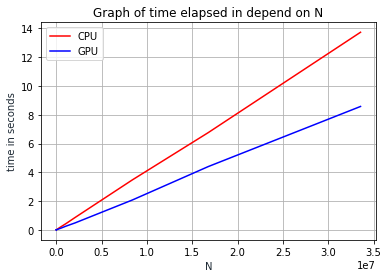

In [76]:
plot(lambda x: rectangles_midle(f, -100, 100, x), lambda x: rectangles_GPU_midle(-100, 100, x))

In [0]:
def trapeze_GPU(a, b, N):
  h = np.float32((b - a) /  (N - 1))
  arr = np.empty(N)
  arr = arr.astype(np.float32)
  arr_gpu = cuda.mem_alloc(arr.nbytes)
  cuda.memcpy_htod(arr_gpu, arr)
  
  mod = SourceModule("""
    __device__ float f(float x)
    {
      return tanh(x);
    }

    __global__ void trapeze(float *arr, float h, float a, int N, int count)
    {
      int k = threadIdx.x;
      for(int i = 0; i < count; ++i)
      {
        int idx = k + i * 1024; 
        float x_k = a + h * idx;
        arr[idx] = f(x_k);
        if(idx > 0 && idx < N - 1)
          arr[idx] *= 2;
      }
    }
    """)
  func = mod.get_function("trapeze")
  count = N // 1024
  count = np.int32(count if count != 0 else 1)
  a = np.float32(a)
  N_arg = np.int32(N)
  func(arr_gpu, h, a, N_arg, count, block=(1024 if N > 1024 else N,1,1))
  arr_res = np.empty_like(arr)
  cuda.memcpy_dtoh(arr_res, arr_gpu)
  return h / 2 * sum(arr_res)

In [0]:
def trapeze(f, a, b, N):
  h = (b - a) / (N - 1)
  return h / 2 * (sum(list(map(lambda k: 2 * f(a + h * k), range(1, N - 1)))) + f(a) + f(b))

In [124]:
trapeze(f, -100, 100, 1024*1024)

0.0

In [129]:
trapeze_GPU(-100, 100, 1024*1024)

7.629815408486654e-06

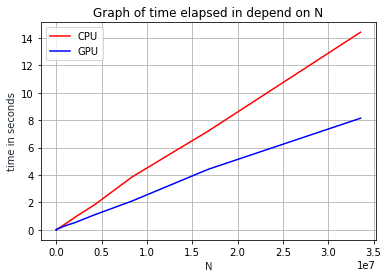

In [130]:
plot(lambda x: trapeze(f, -100, 100, x), lambda x: trapeze_GPU(-100, 100, x))

In [0]:
def simpson_GPU(a, b, N):
  h = np.float32((b - a) /  (N - 1))
  arr = np.empty(N)
  arr = arr.astype(np.float32)
  arr_gpu = cuda.mem_alloc(arr.nbytes)
  cuda.memcpy_htod(arr_gpu, arr)
  
  mod = SourceModule("""
    __device__ float f(float x)
    {
      return tanh(x);
    }

    __global__ void trapeze(float *arr, float h, float a, int N, int count)
    {
      int k = threadIdx.x;
      for(int i = 0; i < count; ++i)
      {
        int idx = k + i * 1024; 
        float x_k = a + h * idx;
        arr[idx] = f(x_k);
        if(idx > 0 && idx < N - 1)
          arr[idx] *= 2;
      }
    }
    """)
  func = mod.get_function("trapeze")
  count = N // 1024
  count = np.int32(count if count != 0 else 1)
  a = np.float32(a)
  N_arg = np.int32(2* N)
  func(arr_gpu, h, a, N_arg, count, block=(1024 if 2*N-1 > 1024 else 2*N-1,1,1))
  arr_res = np.empty_like(arr)
  cuda.memcpy_dtoh(arr_res, arr_gpu)
  return h / 6 * sum(arr_res)